In [148]:
import qutip as q
import numpy as np
import subprocess
import ffmpeg
import pickle
import os
import re

%matplotlib inline
from matplotlib import rc
from matplotlib import pyplot as plt
font = {'weight' : 'normal',
        'size'   : 18}
rc('font', **font)

from matplotlib.font_manager import FontProperties

Our final goal is to solve understand to solve this Hamiltonian for double quantum sensing

$H = D S_z^2 + \frac{\omega_0}{2}  \,S_z + \frac{\Omega_{rf}}{2}  \,cos(\omega_{rf}t) S_z  + \Omega_1 \, \cos(\omega_1 t) \, \sigma_x$

where $\omega_0$ is the magnetic field $\omega_0 = \gamma B$, $D$ is the zero field splitting, $\Omega_{rf}$ 
is the strength and $\omega_{rf}$ is the frequency of the strong longitudinal RF field, finally we have the 
control field $\Omega_1$ given the transitions between energy levels.

Firat we define the operators and verify all variables with FID/rabi oscillations

In [271]:
#resonance frequency D \pm ws
ws = 0.01e3
D = 2.86e3

def get_Hdc():
    Hdc = ws * sz * 2 * np.pi+ D*(sz**2) * 2 * np.pi
    return Hdc
get_Hdc()

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[18032.74183161     0.             0.        ]
 [    0.             0.             0.        ]
 [    0.             0.         17907.07812546]]

In [273]:
#Frequency
Omega = 1
Omega *= 2 * np.pi

# NV hamiltonian
sx = q.spin_Jx(1)
sy = q.spin_Jy(1)
sz = q.spin_Jz(1)



Hdc = get_Hdc()

#time list
time_x=1
t = np.linspace(0, time_x, 10000)

#initial state
a = 90
phi =np.cos(np.deg2rad(a)/2)*q.basis(3,1) + np.sin(np.deg2rad(a)/2)* q.basis(3,2) 

rho_nv = phi*phi.dag()
rho_nv


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.  0.  0. ]
 [0.  0.5 0.5]
 [0.  0.5 0.5]]

0.00010001000100010001


Text(0, 0.5, 'FFT(<Sy>)')

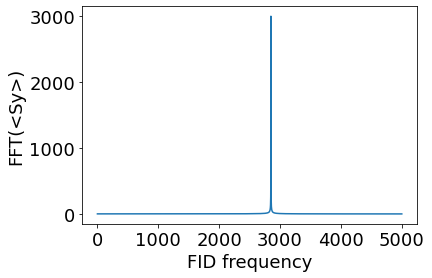

In [274]:
resultat = []
resultat.append(q.mesolve(H=Hdc, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))

dt = t[1]-t[0]
print(dt)
freq_axis = np.fft.rfftfreq(t.size, dt)
data = q.expect(resultat[0].states, sx)

#plot Fourier of the FID
plt.plot(freq_axis,np.abs(np.fft.rfft(data)))
plt.xlabel('FID frequency')
plt.ylabel('FFT(<Sy>)')

## Time dependant Hamiltonian

### First only Probe and 3LS - no Floquet

In [275]:
Omega = 1 #MHz
Omegarf = 0.04

#time independant
Hdc = get_Hdc() #MHz

#time dependant
H1 = Omega * sx * 2 * np.pi


Hrf = Omegarf * sz

#time dependant functions
def Hx1_coeff(t,args):
    freq = args['freq1']
    return np.sin(2 * np.pi *freq * t)



def Hxprobe_coeff(t,args):
    freq = args['freqp'] 
    phase = args['phasep']
    return np.sin(2 * np.pi *freq * t + phase)


#Overall Hamiltonian
H = [Hdc,[H1,Hxprobe_coeff]] #[Hrf,Hx1_coeff],
H

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[18032.74183161     0.             0.        ]
  [    0.             0.             0.        ]
  [    0.             0.         17907.07812546]],
 [Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
  Qobj data =
  [[0.         4.44288294 0.        ]
   [4.44288294 0.         4.44288294]
   [0.         4.44288294 0.        ]],
  <function __main__.Hxprobe_coeff(t, args)>]]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


<ipython-input-278-2106111c769c>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(length)):


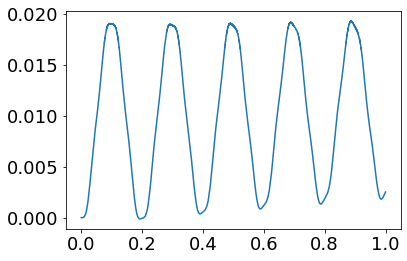

In [278]:
#initial state
phi = q.basis(3,1)
rho_nv = phi*phi.dag()
print(rho_nv)

startf = -15
stopf = 15

odmr_frq = []
odmr = []
length=50
wrf = 1
phase = 0

freqs  = np.linspace(startf,stopf,length)
from tqdm import tqdm_notebook as tqdm

for k in tqdm(range(length)):
    wodmr = freqs[k] + 2860
    odmr_frq.append(wodmr)
    output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], 
                       options=q.Options(nsteps=100000), args={'freqp': wodmr, 'phasep': phase})
    odmr.append(q.expect(output.states, sz)[-1])
    
plt.plot(t,q.expect(output.states, sz))

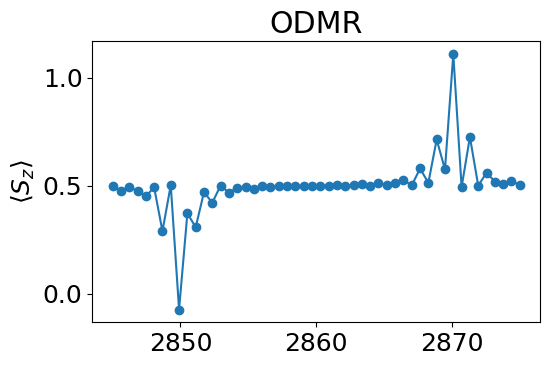

In [279]:
plt.figure(dpi = 100)

plt.title('ODMR')
plt.plot(odmr_frq,np.asarray(odmr)+0.5,marker = 'o', linestyle = '-')

plt.ylabel('$\\langle S_z \\rangle$')

plt.tight_layout()
plt.savefig('pure-odmr.png')

## ODMR with Floquet

In [280]:
Omega = 2 #MHz
Omegarf = 10 * 2 * np.pi

#time independant
Hdc = get_Hdc() #MHz

#time dependant
H1 = Omega * sx * 2 * np.pi
Hrf = Omegarf * sz

#time dependant functions
def Hx1_coeff(t,args):
    freq = args['freq1']
    return np.sin(2 * np.pi *freq * t)



def Hxprobe_coeff(t,args):
    freq = args['freqp'] 
    phase = args['phasep']
    return np.sin(2 * np.pi *freq * t + phase)


#Overall Hamiltonian
H = [Hdc,[H1,Hxprobe_coeff],[Hrf,Hx1_coeff],] #[Hrf,Hx1_coeff],

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


<ipython-input-307-cc3dd25ebeea>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(range(length)):


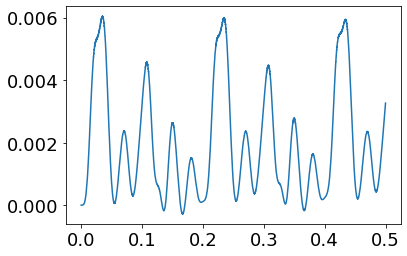

In [307]:
#initial state
phi = q.basis(3,1)
rho_nv = phi*phi.dag()
print(rho_nv)

startf = -35
stopf = 35

odmr_frq = []
odmr = []
length=150
wrf = 10
phase = 0

dq = []

#time list
time_x=0.5
t = np.linspace(0, time_x, 5000)



freqs  = np.linspace(startf,stopf,length)

from tqdm import tqdm_notebook as tqdm

for k in tqdm(range(length)):
    wodmr = freqs[k] + 2860
    odmr_frq.append(wodmr)
    output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], 
                       options=q.Options(nsteps=100000), args={'freqp': wodmr, 'phasep': phase, 'freq1':wrf})
    odmr.append(q.expect(output.states, sz)[-1])
    dq.append(q.expect(output.states, sz**2)[-1])
plt.plot(t,q.expect(output.states, sz))

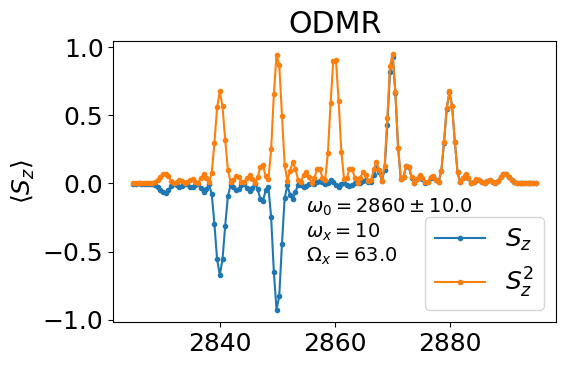

In [321]:
plt.figure(dpi = 100)

plt.title('ODMR')
plt.plot(odmr_frq,np.asarray(odmr),marker = '.', linestyle = '-',label='$S_z$')
plt.plot(odmr_frq,np.asarray(dq),marker = '.', linestyle = '-',label='$S_z^2$')
plt.legend(loc=4)
plt.ylabel('$\\langle S_z \\rangle$')

comment = f'$\\omega_0 = 2860 \\pm {ws} $'
comment += '\n'
comment += f'$\\omega_x = {wrf}$'
comment += '\n'
comment += f'$\\Omega_x = {np.round(Omegarf)}$'


plt.text(2855, -0.1, comment, fontsize=14,
        verticalalignment='top')


plt.tight_layout()
plt.savefig('floquet-odmr-triplet-success.png')

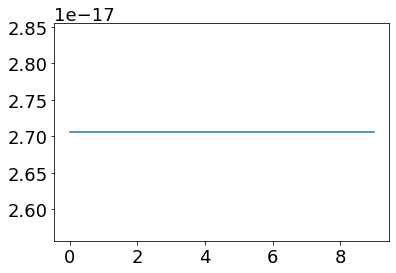

In [147]:
plt.plot(odmr)